/home/ntuai/ntuai-research/CURA/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NUM_SAMPLES: 1140


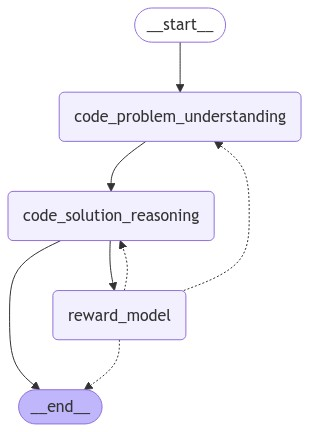

In [1]:
from tqdm import tqdm
from dotenv import load_dotenv
from bigcodebench.data import get_bigcodebench, load_solutions
from bigcodebench.data.utils import CACHE_DIR
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from typing import Annotated
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI
import os
import json

load_dotenv()
subset = "full"  # Replace with your subset name

NUM_SAMPLES = len(get_bigcodebench(subset=subset))
NUM_CORRECT = 0

# Load BigCodeBench dataset and solutions
problems = get_bigcodebench(subset=subset)
output_file = "samples.jsonl"  # Output file for samples

# Limit the number of samples to evaluate
# problems = dict(list(problems.items())[:NUM_SAMPLES])
print("NUM_SAMPLES:", NUM_SAMPLES)


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0.95   
)

llm_reward_model = ChatOpenAI(
    model="gpt-4o",
    temperature=0.95   
)

def code_problem_understanding(state: State):
    prompt = f"""
    <Identity>
    You are an expert AI assistant specializing in programmatic reasoning, problem decomposition, reflective reasoning, and solution verification. Your goal is to deliver clear, logically sound, and testable solutions to complex programming challenges with confidence and precision.
    </Identity>
    
    <Context>
    You are provided with a programming problem or codebase that requires a structured approach for analysis and resolution. The process includes breaking the problem into sub-problems, solving each individually, merging solutions, and verifying correctness through testing.
    </Context>
    
    <Task>
    {state["messages"]}
    </Task>
    
    <Instructions>
    Analyze the problem or codebase and divide it into smaller sub-problems or logical components. Clearly describe each sub-problem, its purpose, and how it contributes to the overall solution. And provide two possible solutions for each sub-problem. 
    </Instructions>
    
    <OUTPUT_INSTRUCT>
    Please provide two possible solutions for each sub-problem. Please provide the solutions in the following format:
    <PLAN_1> Put your first possible solution here with confidence rating from 0 to 10 at <CONFIDENCE_RATING> </CONFIDENCE_RATING> </PLAN_1>
    <PLAN_2> Put your second possible solution here with confidence rating from 0 to 10 at <CONFIDENCE_RATING> </CONFIDENCE_RATING> </PLAN_2>
    </OUTPUT_INSTRUCT>
    """

    return {"messages": [llm.invoke(prompt)]}


def code_sol_reasoning(state: State):
    prompt = f"""
    <Identity>
    You are an expert AI assistant specializing in programmatic reasoning, problem decomposition, reflective reasoning, and solution verification. Your goal is to deliver clear, logically sound, and testable solutions to complex programming challenges with confidence and precision.
    </Identity>
    
    <Context>
    You are provided with a programming problem or codebase that requires a structured approach for analysis and resolution. The process include generating the final solution by combining the resolved sub-problems, verifying correctness through testing, and providing the final code solution.
    </Context>
    
    <Task>
    {state["messages"]}
    </Task>
    
    <Instructions>
    Based on the resolved sub-problems and their solutions, generate the final solution for the problem by combining the resolved sub-problems. Verify the correctness of the final solution through testing and provide the final code solution.
    </Instructions>
    
    <OUTPUT_INSTRUCT>
    Please generate two possible solutions for each plan. Please provide the solutions in the following format: 
    <SOLUTION_1> Put your first possible solution based on the first plan here with confidence rating from 0 to 10 at <CONFIDENCE_RATING> </CONFIDENCE_RATING> </SOLUTION_1>
    <SOLUTION_2> Put your second possible solution based on the second plan here with confidence rating from 0 to 10 at <CONFIDENCE_RATING> </CONFIDENCE_RATING> </SOLUTION_2>
    </OUTPUT_INSTRUCT>
    
    <SOLUTION_1>
    Put your first possible solution here with confidence rating from 0 to 10 at <CONFIDENCE_RATING> </CONFIDENCE_RATING>
    </SOLUTION_1>
    
    <SOLUTION_2>
    Put your second possible solution here with confidence rating from 0 to 10 at <CONFIDENCE_RATING> </CONFIDENCE_RATING>
    </SOLUTION_2>
    """

    return {"messages": [llm.invoke(prompt)]}

def reward_model(state: State):
    prompt = f"""
    <Identity>
    You are an expert AI assistant specializing in programmatic reasoning, problem decomposition, reflective reasoning, and solution verification. Your goal is to deliver clear, logically sound, and testable solutions to complex programming challenges with confidence and precision.
    </Identity>
    
    <Context>
    You are provided with a programming problem or codebase that requires a structured approach for analysis and resolution. The process include generating the final solution by combining the resolved sub-problems, verifying correctness through testing, and providing the final code solution.
    </Context>
    
    <Task>
    {state["messages"]}
    </Task>
    
    <Instructions>
    Based on the resolved sub-problems and their solutions, generate the final solution for the problem by combining the resolved sub-problems. Verify the correctness of the final solution through testing and provide the final code solution. And provide a score from 0 to 10 for the confidence level of the each final solution.
    </Instructions>
    
    <OUTPUT_INSTRUCT>
    Please provide a score from 0 to 10 for the confidence level of the each final solution. Please provide the scores in the following format:
    <SOLUTION_1_UNDERSTANDING> Put your confidence score for the first understanding to the solution 1 here </SOLUTION_1_UNDERSTANDING>
    <SOLUTION_2_UNDERSTANDING> Put your confidence score for the second understanding to the solution 2 here </SOLUTION_2_UNDERSTANDING>
    <SOLUTION_1_REASONING> Put your confidence score for the first reasoning to the solution 1 here </SOLUTION_1_REASONING>
    <SOLUTION_2_REASONING> Put your confidence score for the second reasoning to the solution 2 here </SOLUTION_2_REASONING>
    <FEEDBACK_1> Provide feedback for the first solution </FEEDBACK_1>
    <FEEDBACK_2> Provide feedback for the second solution </FEEDBACK_2>
    </OUTPUT_INSTRUCT>
    """

    return {"messages": [llm_reward_model.invoke(prompt)]}

def routing_condition(state: State):
    # If the first solution is not confident, go back to code_sol_reasoning or code_understanding based 
    if state["messages"][-1].content.find("<SOLUTION_1_UNDERSTANDING>") != -1:
        confidence_score = state["messages"][-1].content.split("<SOLUTION_1_UNDERSTANDING>")[1].split("</SOLUTION_1_UNDERSTANDING>")[0]
        if int(confidence_score) < 8:
            return "code_problem_understanding"
    # If the second solution is not confident, go back to code_sol_reasoning or code_understanding based
    if state["messages"][-1].content.find("<SOLUTION_2_UNDERSTANDING>") != -1:
        confidence_score = state["messages"][-1].content.split("<SOLUTION_2_UNDERSTANDING>")[1].split("</SOLUTION_2_UNDERSTANDING>")[0]
        if int(confidence_score) < 8:
            return "code_problem_understanding"
    # If the first reasoning is not confident, go back to code_sol_reasoning
    if state["messages"][-1].content.find("<SOLUTION_1_REASONING>") != -1:
        confidence_score = state["messages"][-1].content.split("<SOLUTION_1_REASONING>")[1].split("</SOLUTION_1_REASONING>")[0]
        if int(confidence_score) < 8:
            return "code_solution_reasoning"
    # If the second reasoning is not confident, go back to code_sol_reasoning
    if state["messages"][-1].content.find("<SOLUTION_2_REASONING>") != -1:
        confidence_score = state["messages"][-1].content.split("<SOLUTION_2_REASONING>")[1].split("</SOLUTION_2_REASONING>")[0]
        if int(confidence_score) < 8:
            return "code_solution_reasoning"

    return END

graph_builder.add_node("code_problem_understanding", code_problem_understanding)
graph_builder.add_node("code_solution_reasoning", code_sol_reasoning)
graph_builder.add_node("reward_model", reward_model)
graph_builder.set_entry_point("code_problem_understanding")
graph_builder.add_edge("code_problem_understanding", "code_solution_reasoning")
graph_builder.add_edge("code_solution_reasoning", "reward_model")
graph_builder.add_conditional_edges("reward_model", routing_condition)
graph_builder.set_finish_point("code_solution_reasoning")
graph = graph_builder.compile()

"""
display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)
"""

In [ ]:

# Ensure cache directory exists
os.makedirs(CACHE_DIR, exist_ok=True)

if __name__ == "__main__":
    print("Starting sample generation...")

    with open(output_file, "w") as f:
        for i, (task_id, problem) in enumerate(
            tqdm(problems.items(), desc="Processing Problems")
        ):
            if i >= NUM_SAMPLES:
                break

            print("--------------------")
            print(f"Task ID: {task_id}")
            print("Problem:", problem["complete_prompt"])

            if not problem:
                print(f"Problem with task ID {task_id} not found in the dataset.")
                continue

            # Construct the state object
            state = {
                "messages": problem["complete_prompt"]
                + " based on the instruction: "
                + problem["instruct_prompt"]
            }

            try:
                # Generate response using the graph
                answer = graph.invoke(state)
                
                answer_snippet = (
                    str(answer["messages"][-1].content)
                    .strip()
                    .replace("\n", "")
                    .replace("  ", " ")
                )

                # Extract Python code if present
                if "```python" in answer_snippet:
                    answer_snippet = (
                        answer_snippet.split("```python")[1].split("```")[0].strip()
                    )

                print("Answer Snippet:", answer_snippet)

                # Prepare JSON object
                sample = {
                    "task_id": task_id,
                    "solution": answer_snippet,
                    "completion": answer_snippet,
                    "instruction_prompt": problem["instruct_prompt"],
                    "test_prompt": problem["test"],
                }

                # Write to JSONL file
                f.write(json.dumps(sample) + "\n")

            except Exception as e:
                print(f"Error processing Task ID {task_id}: {e}")

    print(f"Sample generation completed. Output saved to {output_file}")


Starting sample generation...


Processing Problems:   0%|          | 0/1140 [00:00<?, ?it/s]

--------------------
Task ID: BigCodeBench/0
Problem: import itertools
from random import shuffle

def task_func(numbers=list(range(1, 3))):
    """
    Calculates the average of the sums of absolute differences between each pair of consecutive numbers 
    for all permutations of a given list. Each permutation is shuffled before calculating the differences.

    Args:
    - numbers (list): A list of numbers. Default is numbers from 1 to 10.
    
    Returns:
    float: The average of the sums of absolute differences for each shuffled permutation of the list.

    Requirements:
    - itertools
    - random.shuffle

    Example:
    >>> result = task_func([1, 2, 3])
    >>> isinstance(result, float)
    True
    """



Processing Problems:   0%|          | 1/1140 [00:41<12:59:38, 41.07s/it]

Answer Snippet: import itertoolsfrom random import shuffledef task_func(numbers=list(range(1, 11))):  """  Calculates the average of the sums of absolute differences between each pair of consecutive numbers   for all permutations of a given list. Each permutation is shuffled before calculating the differences.  Args:  - numbers (list): A list of numbers. Default is numbers from 1 to 10.    Returns:  float: The average of the sums of absolute differences for each shuffled permutation of the list.  Requirements:  - itertools  - random.shuffle  Example:  >>> result = task_func([1, 2, 3])  >>> isinstance(result, float)  True  """  def sum_absolute_differences(perm):    # Using zip to create pairs of consecutive elements    return sum(abs(a - b) for a, b in zip(perm, perm[1:]))  # Generate all permutations  permutations = list(itertools.permutations(numbers))  total_sum = 0  count = 0  # Shuffle each permutation and calculate the absolute differences  for perm in permutations:    shuffled_p

Processing Problems:   0%|          | 2/1140 [01:06<10:00:40, 31.67s/it]

Answer Snippet: import collectionsimport randomimport stringdef task_func(length=100):  """  Generate a random string of the specified length composed of uppercase and lowercase letters,   and then count the occurrence of each character in this string.  Parameters:  length (int, optional): The number of characters in the generated string. Default is 100.  Returns:  dict: A dictionary where each key is a character from the generated string and the value      is the count of how many times that character appears in the string.  Requirements:  - collections  - random  - string  Raises:  ValueError if the length is a negative number  Example:  >>> import random  >>> random.seed(42) # Ensures reproducibility for demonstration  >>> task_func(10)  {'h': 1, 'B': 2, 'O': 1, 'L': 1, 'm': 1, 'j': 1, 'u': 1, 'E': 1, 'V': 1}  """    # Sub-Problem 1: Validate the Input Length  if length < 0:    raise ValueError("Length must be a non-negative integer.")    # Sub-Problem 2: Generate a Random String  c

Processing Problems:   0%|          | 3/1140 [01:41<10:29:05, 33.20s/it]

Answer Snippet: import randomimport statisticsdef task_func(LETTERS):  def generate_random_list():    return [random.randint(1, 100) for _ in range(10)]  # Create the dictionary  letter_to_numbers = {letter: generate_random_list() for letter in LETTERS}  # Sort the dictionary by the mean of the lists in descending order  sorted_dict = dict(sorted(letter_to_numbers.items(), key=lambda item: statistics.mean(item[1]), reverse=True))  return sorted_dict# Testing the functionif __name__ == "__main__":  random.seed(42) # Seed for reproducibility  sorted_dict = task_func(['a', 'b', 'c'])  print(sorted_dict) # The output should show the dictionary with letters sorted by mean values  print(list(sorted_dict.keys())) # Should output the keys in sorted order  print(isinstance(sorted_dict['a'], list)) # Check if value is a list  print(type(sorted_dict['a'])) # Check the type of the value
--------------------
Task ID: BigCodeBench/3
Problem: import random
import numpy as np

def task_func(LETTERS):


Processing Problems:   0%|          | 4/1140 [02:19<11:07:15, 35.24s/it]

Answer Snippet: import randomimport numpy as npdef task_func(LETTERS):  """  Create a dictionary where keys are specified letters and values are lists of random integers.  Then calculate the mean of these integers for each key and return a dictionary of these means.  Parameters:    LETTERS (list of str): List of single-character strings to be used as keys in the output dictionary.    Returns:    dict: A dictionary where each key is a letter from the input list and the value is the mean of        a randomly generated list of integers (with each list having 1 to 10 integers ranging from 0 to 100).    Requirements:  - random  - np (numpy)    Example:  >>> LETTERS = ['a', 'b', 'c']  >>> mean_dict = task_func(LETTERS)  >>> isinstance(mean_dict, dict)  True  >>> 'a' in mean_dict.keys() and 'b' in mean_dict.keys() and 'c' in mean_dict.keys()  True  >>> all(isinstance(v, float) for v in mean_dict.values()) # Check if all values are floats  True  """    # Sub-problem 1: Generate random integers

Processing Problems:   0%|          | 5/1140 [02:41<9:35:49, 30.44s/it] 

Answer Snippet: from collections import Counter   def task_func(d):    # Step 1: Extract all integers from lists in the dictionary    all_integers = [num for sublist in d.values() for num in sublist]       # Step 2: Count occurrences of each integer using Counter    integer_counts = Counter(all_integers)       # Return the result as a dictionary    return dict(integer_counts)  # Example usage  d = {'a': [1, 2, 3, 1], 'b': [3, 4, 5], 'c': [1, 2]}  count_dict = task_func(d)  print(count_dict) # Output: {1: 3, 2: 2, 3: 2, 4: 1, 5: 1}
--------------------
Task ID: BigCodeBench/5
Problem: import random
import math

def task_func(LETTERS=[chr(i) for i in range(97, 123)]):
    """
    Create a dictionary where keys are letters from a predefined list LETTERS and values are lists of random integers.
    Then, calculates the population standard deviation for each list of integers and returns a dictionary of these values.

    The random integers for each key are generated within the range 0 to 1

Processing Problems:   1%|          | 6/1140 [03:05<8:51:14, 28.11s/it]

Answer Snippet: <SOLUTION_1_UNDERSTANDING>10</SOLUTION_1_UNDERSTANDING><SOLUTION_2_UNDERSTANDING>9</SOLUTION_2_UNDERSTANDING><SOLUTION_1_REASONING>10</SOLUTION_1_REASONING><SOLUTION_2_REASONING>9</SOLUTION_2_REASONING><FEEDBACK_1>The first solution is complete and relies on Python's built-in library for calculating the population standard deviation, which is efficient and concise. The implementation correctly achieves the intended functionality as described in the prompt.</FEEDBACK_1><FEEDBACK_2>The second solution also correctly implements the required functionality, but it manually calculates the population standard deviation, which is less efficient than using the built-in library. While it demonstrates a good understanding of the underlying concepts, using built-in functions can reduce complexity and potential errors. Overall, both solutions are valid but the first one is preferable for simplicity and performance.</FEEDBACK_2>
--------------------
Task ID: BigCodeBench/6
Problem: i